In [141]:
import pandas
import matplotlib.pyplot as plt

In [31]:
url_confirmed = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_recovered = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [32]:
raw_df_confirmed = pandas.read_csv(url_confirmed)
raw_df_recovered = pandas.read_csv(url_recovered)

In [119]:
df_c = raw_df_confirmed.copy()
df_r = raw_df_recovered.copy()

In [120]:
for df in (df_c, df_r):
    del df['Long']
    del df['Lat']

In [121]:

df_c, df_r = [df.set_index(['Country/Region','Province/State']).transpose() for df in (df_c, df_r)]

In [122]:
df_c, df_r = [df.set_index(pandas.to_datetime(df.index)) for df in (df_c, df_r)]

In [297]:
def get_from_n(n, colname, df):
    vals = (df[colname] - n).abs()
    min_dist = vals.min()
    shift = (df.index[(vals == min_dist).values.flatten()][0] - df.index[0]).days
    return df.reset_index()[colname].shift(-shift).dropna()

In [166]:
import numpy

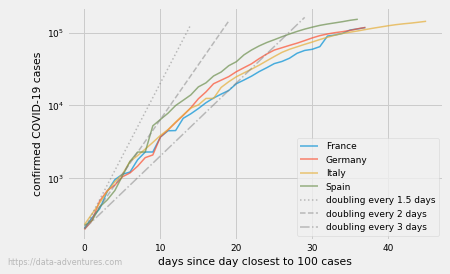

In [307]:
N = 200
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
for country in ('France', 'Germany', 'Italy', 'Spain',):
    get_from_n(N, (country, float('nan')), df_c).plot.line(label=country, alpha=0.7)
plt.plot([N*2**(i/1.5) for i in range(15)], ":", alpha=0.5, label='doubling every 1.5 days', color='grey')
plt.plot([N*2**(i/2) for i in range(20)], "--", alpha=0.5, label='doubling every 2 days', color='grey')
plt.plot([N*2**(i/3) for i in range(30)], "-.", alpha=0.5, label='doubling every 3 days',  color='grey')
plt.yscale('log')
plt.xlabel("days since day closest to 100 cases")
plt.ylabel("confirmed COVID-19 cases")
plt.legend()
plt.text(5, 60, 'data-adventures.com',
         fontsize=8, color='gray',
         ha='right', va='bottom', alpha=0.5)
plt.savefig('confirmed_cases.png', dpi=300, bbox_inches='tight')

In [190]:
def get_interval(n, N, colname, df):
    shift = (df.index[((df[colname] >= n)).values.flatten()][0] - df.index[0]).days
    last = (df.index[((df[colname] > N)).values.flatten()][0] - df.index[0]).days
    return df.reset_index()[colname].shift(-shift).dropna()[:last - shift]

In [179]:
import statsmodels.api as sm

In [229]:
def fit_onset(n, N, country):
    y = numpy.log(get_interval(n, N, (country, float('nan')), df_c))
    X = numpy.arange(0, len(y))
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    fit = model.fit()
    print(fit.summary2())
    return fit.params

In [239]:
params = {c: fit_onset(200, 10e4, c) for c in ('Spain', 'Italy', 'France', 'Germany')}

Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.959   
Dependent Variable: ('Spain', nan)   AIC:                28.9727 
Date:               2020-04-11 14:42 BIC:                31.6371 
No. Observations:   28               Log-Likelihood:     -12.486 
Df Model:           1                F-statistic:        628.6   
Df Residuals:       26               Prob (F-statistic): 9.66e-20
R-squared:          0.960            Scale:              0.15383 
--------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const    5.9427      0.1444    41.1662    0.0000    5.6460    6.2394
x1       0.2301      0.0092    25.0725    0.0000    0.2112    0.2489
-----------------------------------------------------------------
Omnibus:               5.306        Durbin-Watson:          0.178
Prob(Omnibus):         0.070 

In [252]:
import sklearn
import scipy.stats

In [262]:
N = 1000
bs_r = [numpy.mean(sklearn.utils.resample([params[k]['x1'] for k in params])) for i in range(200)]
R_est = [1 + r*Tc for r, Tc in zip(bs_r, numpy.random.normal(5.2, 1, 1000))]

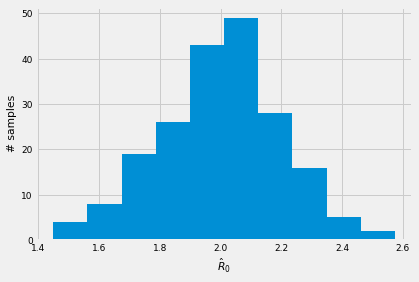

In [272]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.hist(R_est, bins=10)
plt.xlabel('$\hat R_0$')
plt.ylabel('# samples')
plt.savefig("R0.png", dpi=300)

In [265]:
numpy.percentile(R_est, (5, 50, 95))

array([1.66566776, 2.01328791, 2.31498847])

In [ ]:
r_df = pandas.DataFrame({'R0': []})

In [210]:
1 + fit.params['x1'] * 5

2.2761680861625875

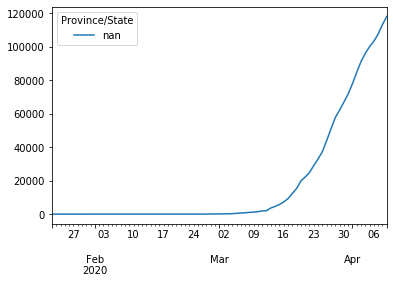

In [89]:
df_c['Germany'].plot.line()

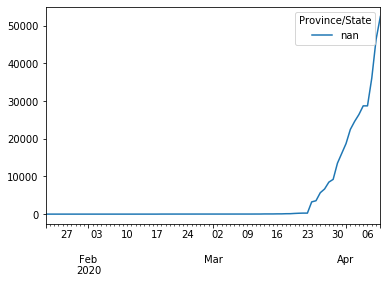

In [90]:
df_r['Germany'].plot.line()

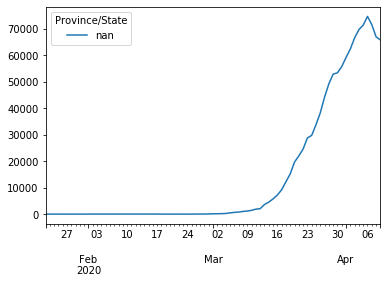

In [91]:
active = (df_c['Germany'] - df_r['Germany'])
active.plot.line()

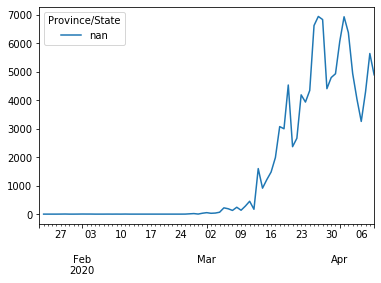

In [92]:
new = (df_c['Germany'] - df_c['Germany'].shift(1))
new.plot.line()

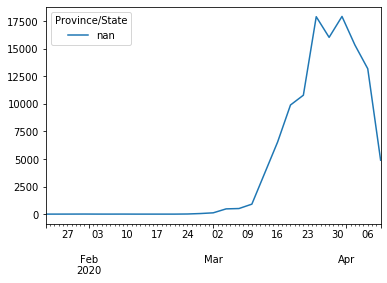

In [96]:
new.resample('3d').sum().plot.line()

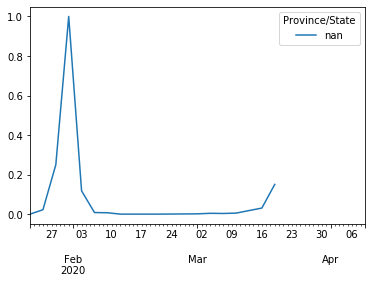

In [94]:
(new.resample('3d').sum() / active.resample('3d').sum().shift(-7)).plot.line()